# Análise exploratória em sRNAs

Bancos de dados utilizados:
* RegulonDB (https://regulondb.ccg.unam.mx)
* SRD: Staphylococcal Regulatory RNAs Database (http://srd.genouest.org/): SRD proposes a simplified and unified identifier for Staphylococcal regulatory RNAs (srn) based on the sRNA’s genetic location in S. aureus strain N315 which served as a reference. SRD provides a list of 575 srn potentially exempt of repeated sequences.

# Importação das bibliotecas

In [1]:
from collections import Counter

import tempfile
import utils.feature_extraction as fe
import utils.outliers as outliers

import itertools

import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import seaborn as sns
# sns.set(style="whitegrid")


# Carregamento dos datasets

In [2]:
dsfiles = [
    {'bd': 'PresRAT', 'file': 'data/PresRAT/sRNA_total.100cl_1.csv'},
    {'bd': 'RegulonDB', 'file': './data/RegulonDB/sRNASet.csv'},
    {'bd': 'SRD', 'file': './data/SRD/sRNA_JKD6008.csv'},
    {'bd': 'SRD', 'file': './data/SRD/sRNA_N315.csv'},
    {'bd': 'SRD', 'file': './data/SRD/sRNA_NCTC8325.csv'},
    {'bd': 'SRD', 'file': './data/SRD/sRNA_Newman.csv'},
    {'bd': 'SRD', 'file': './data/SRD/sRNA_USA300_FPR3757.csv'},
    {'bd': 'CoryneRegNet', 'file': './data/CoryneRegNet/CoryneRegNet_rna.csv'},
    {'bd': 'CoryneRegNet', 'file': './data/CoryneRegNet/CoryneRegNet_rna_exp.csv'},
    {'bd': 'CoryneRegNet', 'file': './data/CoryneRegNet/CoryneRegNet_rna_pred.csv'},
    # {'bd': 'Rfam', 'file': './data/Rfam/raw.csv'},
    {'bd': 'Rfam', 'file': './data/Rfam/bacteria.csv'}
]

dsfiles_repeats = ['CoryneRegNet']

In [3]:
dflist = [ pd.read_csv(dsfile['file']) for dsfile in dsfiles ]
df = pd.concat(dflist, axis=0)

print('Shape=', df.shape)

Shape= (52916, 99)


In [4]:
df.rename({'label': 'dataset'}, axis=1, inplace=True)

df['GC_Content'] = df['G'] + df['C']

df['GC_Ratio'] = df['G'] / df['C']
c = np.isinf(df['GC_Ratio']).values
df.loc[c, 'GC_Ratio'] = 1
df.loc[df['GC_Ratio'].isnull(), 'GC_Ratio'] = 1

df_without_repeats = df.loc[~df['dataset'].isin(dsfiles_repeats)]

del c

In [5]:
# Definir especies para os registros
df['specie'] = 'all'

# Configurações

In [6]:
ds_config = {
  'PresRAT_sRNA': {'title': 'PresRAT - Several bacteria', 'group': 'PresRAT'},
  'RegulonDB_sRNASet': {'title': 'RegulonDB - E. coli - Exp', 'group': 'RegulonDB'},
  'SRD_sRNA_JKD6008': {'title': 'SRD - S. aureus JKD6008', 'group': 'SRD'},
  'SRD_sRNA_N315': {'title': 'SRD - S. aureus N315', 'group': 'SRD'},
  'SRD_sRNA_NCTC8325': {'title': 'SRD - S. aureus NCTC8325', 'group': 'SRD'},
  'SRD_sRNA_Newman': {'title': 'SRD - S. aureus Newman', 'group': 'SRD'},
  'SRD_sRNA_USA300_FPR3757': {'title': 'SRD - S. aureus USA300_FPR3757', 'group': 'SRD'},
  'CoryneRegNet': {'title': 'CoryneRegNet', 'group': 'CoryneRegNet'},
  'CoryneRegNet-exp': {'title': 'CoryneRegNet - Corynebacterium - Exp*', 'group': 'CoryneRegNet'},
  'CoryneRegNet-pred': {'title': 'CoryneRegNet - Corynebacterium - Pred*', 'group': 'CoryneRegNet'},
  # 'Rfam': {'title': 'Rfam', 'group': 'Rfam'},
  'Rfam_bacteria': {'title': 'Rfam', 'group': 'Rfam'},
}

ds_groups = Counter( [ v['group'] for i,v in ds_config.items() ] )
ds_groups

Counter({'PresRAT': 1, 'RegulonDB': 1, 'SRD': 5, 'CoryneRegNet': 3, 'Rfam': 1})

# Definição de funções

In [7]:
def my_set_xticklabels(ax):
  labels = ax.get_xticklabels()
  labels = [ds_config[x.get_text()]['title'] for x in labels]
  ax.set_xticklabels(labels)

def my_set_yticklabels(ax):
  labels = ax.get_yticklabels()
  labels = [ds_config[y.get_text()]['title'] for y in labels]
  ax.set_yticklabels(labels)

In [8]:
def my_describe(df):
  mydf = df.describe()
  mydf['amplitude'] = mydf['max'] - mydf['min']
  mydf['amplitude2'] = mydf['75%'] - mydf['25%']
  return mydf

In [9]:
# use hex in #000000 format
def hex_to_rgb(hex):
  return tuple(int(hex[i:i+2], 16) for i in (1, 3, 5))

def rgb_to_hex(rgb):
  return '#{:02x}{:02x}{:02x}'.format(*rgb)

def rgb2_to_hex(rgb):
  return rgb_to_hex([ round(i * 255) for i in rgb ])

def rgb_darken(rgb, ratio):
  return [ max(int(color * (1 - ratio)), 0) for color in rgb ]

def rgb_lighten(rgb, ratio):
  return [ min(int(color * (1 + ratio)), 255) for color in rgb ]

def rgb_desaturate1(rgb, ratio):
  bw1 = 0.3 * rgb[0] + 0.59 * rgb[1] + 0.11 * rgb[2]
  r1 = tuple( round(bw1 * ratio + color * (1 - ratio)) for color in rgb )
  return r1

def rgb_desaturate2(rgb, ratio):
  bw2 = (min(rgb) + max(rgb)) / 2
  r2 = tuple( round(bw2 * ratio + color * (1 - ratio)) for color in rgb )
  return r2

# Colors

In [10]:
# sns.set_palette("hls")
# sns.set_palette("husl")
# sns.set_palette("Paired")
# sns.set_palette("RdBu", 11)

In [11]:
dr = 0.8
c = (255,0,0)
r = 5

m1 = [ rgb_to_hex(rgb_desaturate1(c, dr * i / r)) for i in range(r) ]
m2 = [ rgb_to_hex(rgb_desaturate2(c, dr * i / r)) for i in range(r) ]

display( sns.color_palette(m1) )
display( sns.color_palette(m2) )

[(1.0, 0.0, 0.0),
 (0.8862745098039215, 0.047058823529411764, 0.047058823529411764),
 (0.7764705882352941, 0.09411764705882353, 0.09411764705882353),
 (0.6627450980392157, 0.1450980392156863, 0.1450980392156863),
 (0.5529411764705883, 0.19215686274509805, 0.19215686274509805)]

[(1.0, 0.0, 0.0),
 (0.9215686274509803, 0.0784313725490196, 0.0784313725490196),
 (0.8392156862745098, 0.1607843137254902, 0.1607843137254902),
 (0.7607843137254902, 0.23921568627450981, 0.23921568627450981),
 (0.6784313725490196, 0.3215686274509804, 0.3215686274509804)]

In [12]:
# the last color is for lines
pal = sns.color_palette('Dark2', len(ds_groups))
pal

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941)]

In [13]:
desaturate_ratio = 0.8

my_colors = []
for ((group_name, group_qtd), base_color) in zip(ds_groups.items(), pal.as_hex()):
  base_color_rgb = hex_to_rgb(base_color)

  for i in range(group_qtd):
    my_base_color = rgb_to_hex(rgb_desaturate2(base_color_rgb, desaturate_ratio * i / group_qtd))
    my_colors.append( my_base_color )

my_palette = sns.color_palette(my_colors)
my_palette

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.47843137254901963, 0.4588235294117647, 0.6823529411764706),
 (0.49411764705882355, 0.4823529411764706, 0.6588235294117647),
 (0.5137254901960784, 0.5019607843137255, 0.6392156862745098),
 (0.5294117647058824, 0.5215686274509804, 0.6196078431372549),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.807843137254902, 0.25882352941176473, 0.5372549019607843),
 (0.7058823529411765, 0.3607843137254902, 0.5372549019607843),
 (0.4, 0.6509803921568628, 0.11764705882352941)]

In [14]:
lines_color = sns.color_palette('tab10', 10)
display(lines_color)

my_palette_lines = sns.color_palette([ lines_color[i] for i in [2,3,5] ])
display(my_palette_lines)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

[(0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)]

# Visão geral

In [15]:
df[['length', 'A', 'C', 'G', 'T', 'GC_Content', 'GC_Ratio']].describe().T

,count,mean,std,min,25%,50%,75%,max
length,52916.0,121.936560,89.215716,14.00000,71.000000,96.00000,145.000000,4222.000000
A,52916.0,0.240022,0.079015,0.01333,0.179490,0.24348,0.297030,0.565220
C,52916.0,0.253254,0.076183,0.02941,0.196080,0.25000,0.308820,0.571430
G,52916.0,0.258976,0.065085,0.04167,0.214880,0.25620,0.304013,0.529410
T,52916.0,0.247749,0.075129,0.01493,0.193550,0.24194,0.300880,0.576270
GC_Content,52916.0,0.512229,0.119101,0.16000,0.424825,0.50893,0.603310,0.848220
GC_Ratio,52916.0,1.093575,0.369896,0.15386,0.846148,1.04760,1.285686,8.667657


# Quantidade de sequências

In [16]:
# Quantidade por label (dataset)
df.groupby(['dataset'])['dataset'].count()

dataset
CoryneRegNet                 922
CoryneRegNet-exp             805
CoryneRegNet-pred            117
PresRAT_sRNA                1174
RegulonDB_sRNASet            111
Rfam_bacteria              47011
SRD_sRNA_JKD6008             606
SRD_sRNA_N315                549
SRD_sRNA_NCTC8325            538
SRD_sRNA_Newman              555
SRD_sRNA_USA300_FPR3757      528
Name: dataset, dtype: int64

In [17]:
d1 = df_without_repeats['dataset'].count()
d2 = df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), 'dataset'].count()
d3 = df_without_repeats.loc[df_without_repeats['dataset'].isin(['Rfam_bacteria']), 'dataset'].count()

print('Total:', d1)
print('Total (excluindo Rfam):', d2)
print('Total (apenas Rfam):', d3)

(d3 / d1) * 100

Total: 51994
Total (excluindo Rfam): 4983
Total (apenas Rfam): 47011


90.41620186944648

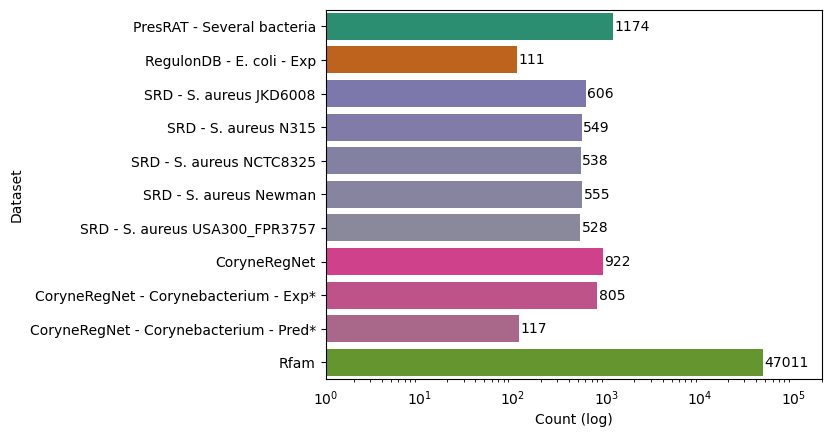

In [57]:
def plot_qtd_sequencias(ax):
  # if ax is None: ax = plt.subplot()
  sns.countplot(data=df, y='dataset',
                     orient='h', palette=my_palette, ax=ax)
  ax.set(ylabel='Dataset', xlabel='Count (log)')
  
  # ax.set(xticklabels=[])
  # ax.set(xlabel=None)
  ax.tick_params(bottom=False)

  my_set_yticklabels(ax)

  # for item in ax.get_xticklabels():
    # item.set_rotation(90)
  ax.bar_label(ax.containers[0], size=10, padding=1)

  ax.set_xlim(1e0, 2e5)
  ax.set_xscale('log')
  return ax

plot_qtd_sequencias(plt.subplot())
plt.show()

# Tamanho das sequências

In [19]:
df.groupby(['dataset'])[['length']].describe()['length'] # .sort_values('min')

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
CoryneRegNet,922.0,76.087852,122.154740,14.0,34.00,40.0,86.00,1961.0
CoryneRegNet-exp,805.0,65.942857,106.559092,14.0,34.00,36.0,69.00,1961.0
CoryneRegNet-pred,117.0,145.888889,184.782527,32.0,92.00,114.0,132.00,1864.0
PresRAT_sRNA,1174.0,162.569847,102.808697,29.0,88.00,130.0,201.00,601.0
RegulonDB_sRNASet,111.0,126.972973,67.455637,53.0,78.50,101.0,160.50,377.0
Rfam_bacteria,47011.0,119.030355,70.940867,30.0,72.00,95.0,143.00,891.0
SRD_sRNA_JKD6008,606.0,175.787129,191.797162,28.0,71.25,137.5,225.00,3454.0
SRD_sRNA_N315,549.0,182.979964,242.669381,28.0,73.00,142.0,226.00,4222.0
SRD_sRNA_NCTC8325,538.0,188.555762,213.487433,28.0,76.00,148.0,235.75,2907.0


In [20]:
# print('Mediana (sem Rfam):', df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), 'length'].median())
# print('Mediana geral:', df_without_repeats['length'].median())

In [21]:
# Menor valor
display(df_without_repeats.loc[df_without_repeats['length'] == df_without_repeats['length'].min()])

,nameseq,length,A,C,G,T,AA,AC,AG,AT,...,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,dataset,GC_Content,GC_Ratio
277,cgb_19066,14,0.07143,0.5,0.21429,0.21429,0.0,0.07692,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CoryneRegNet-exp,0.71429,0.42858


In [22]:
# maior valor
display(df_without_repeats.loc[df_without_repeats['length'] == df_without_repeats['length'].max()])

,nameseq,length,A,C,G,T,AA,AC,AG,AT,...,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,dataset,GC_Content,GC_Ratio
503,N315_srn_4710_Teg34,4222,0.43415,0.1523,0.20867,0.20488,0.18977,0.06444,0.10092,0.07913,...,74.2,3.20894,50.0,11.11111,11.4947,31.00748,0.37071,SRD_sRNA_N315,0.36097,1.370125


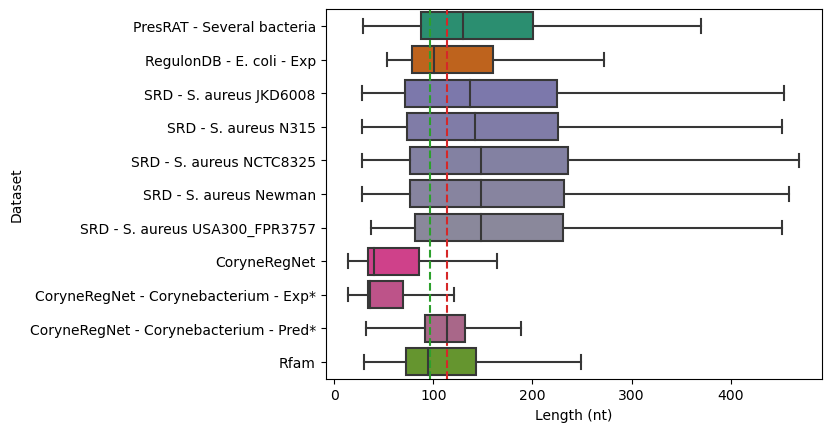

In [66]:
def plot_tamanho_sequencias(ax):
  # Blues, Greens, Greys, Oranges, Purples, Reds
  # Dark2, Paired, Set1
  sns.boxplot(data=df, x='length', y='dataset',
              showfliers=False, palette=my_palette, ax=ax)
  ax.set(xlabel='Length (nt)', ylabel='Dataset')

  my_set_yticklabels(ax)

  median_geral = df_without_repeats['length'].median()
  median_without_rfam = df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), 'length'].median()

  ax.axvline(x=median_geral, linestyle='--', color=my_palette_lines[0])
  ax.axvline(x=median_without_rfam, linestyle='--', color=my_palette_lines[1])

  return ax

plot_tamanho_sequencias(plt.subplot())
plt.show()

# Grafico: Tamanho do dataset + tamanho das sequências

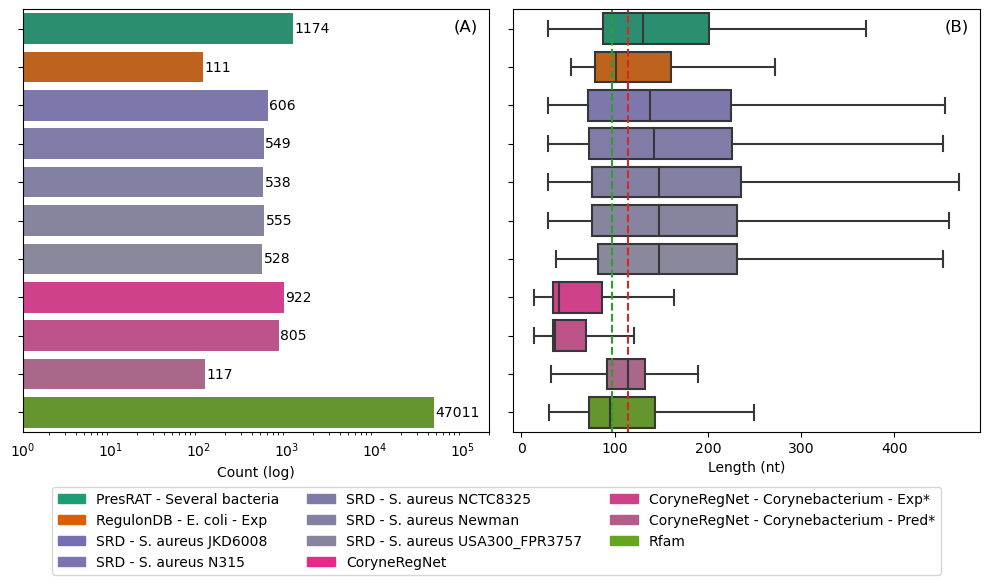

In [80]:
def plot_qtd_tamanho_sequencias():
  cols = ['A', 'B']

  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  labels = None
  for col, ax in zip(cols, axs.flatten()):
    if col == 'A':
      plot_qtd_sequencias(ax)
    else:
      plot_tamanho_sequencias(ax)
    
    ax.set_title('(' + col + ')', x=0.95, y=0.93)

    if labels is None:
      labels = [label.get_text() for label in ax.get_yticklabels()]

    ax.label_outer()
    # ax.set_yticklabels([])
    ax.set(yticklabels=[])
    ax.set(ylabel=None)

  patches = [mpl.patches.Patch(color=my_palette[i], label=label) for i,label in enumerate(labels)]
  fig.legend(handles=patches,
              loc='lower left',
              bbox_to_anchor=(0.05,-0.175),
              ncol=3,
              bbox_transform=fig.transFigure)

  fig.tight_layout()

plot_qtd_tamanho_sequencias()
plt.show()

# Proporção de conteúdo GC

Conforme "Distinguishing mirtrons from canonical miRNAs with data exploration and machine learning methods" (RORBACH; UNOLD; KONOPKA, 2018)

`GC_Content = (G + C) / (A + C + T + G)`


By default, the Seaborn violin plot will extend to two times the interquartile range of the plot. This means that some outliers will be cut. However, violin plots are excellent tools for identifying outliers. Because of this, we can use the cut= parameter to remove (or include) certain outliers.

In [24]:
# Quantidade por label (dataset)
display( my_describe(df.groupby(['dataset'])['GC_Content']) )
display( my_describe(df['GC_Content']) )

,count,mean,std,min,25%,50%,75%,max,amplitude,amplitude2
dataset,,,,,,,,,,
CoryneRegNet,922.0,0.515602,0.081890,0.22222,0.461673,0.512820,0.566743,0.82353,0.60131,0.105070
CoryneRegNet-exp,805.0,0.508411,0.080882,0.22222,0.452050,0.500000,0.558820,0.82353,0.60131,0.106770
CoryneRegNet-pred,117.0,0.565084,0.071223,0.42017,0.512820,0.560000,0.610960,0.81579,0.39562,0.098140
PresRAT_sRNA,1174.0,0.488680,0.116535,0.19394,0.408648,0.485660,0.564350,0.81188,0.61794,0.155702
RegulonDB_sRNASet,111.0,0.481658,0.069486,0.35119,0.428920,0.483740,0.509710,0.66234,0.31115,0.080790
Rfam_bacteria,47011.0,0.523036,0.114853,0.16000,0.437870,0.519480,0.612570,0.84822,0.68822,0.174700
SRD_sRNA_JKD6008,606.0,0.340247,0.065305,0.18571,0.295405,0.338035,0.380000,0.70967,0.52396,0.084595
SRD_sRNA_N315,549.0,0.336768,0.064905,0.18571,0.293480,0.333340,0.375000,0.70967,0.52396,0.081520
SRD_sRNA_NCTC8325,538.0,0.338460,0.064635,0.18571,0.294120,0.337705,0.378713,0.70967,0.52396,0.084593


count         52916.000000
mean              0.512229
std               0.119101
min               0.160000
25%               0.424825
50%               0.508930
75%               0.603310
max               0.848220
amplitude         0.688220
amplitude2        0.178485
Name: GC_Content, dtype: float64

In [25]:
print('Mediana (sem Rfam):', df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), 'GC_Content'].median())
print('Mediana geral:', df_without_repeats['GC_Content'].median())

Mediana (sem Rfam): 0.38626
Mediana geral: 0.50887


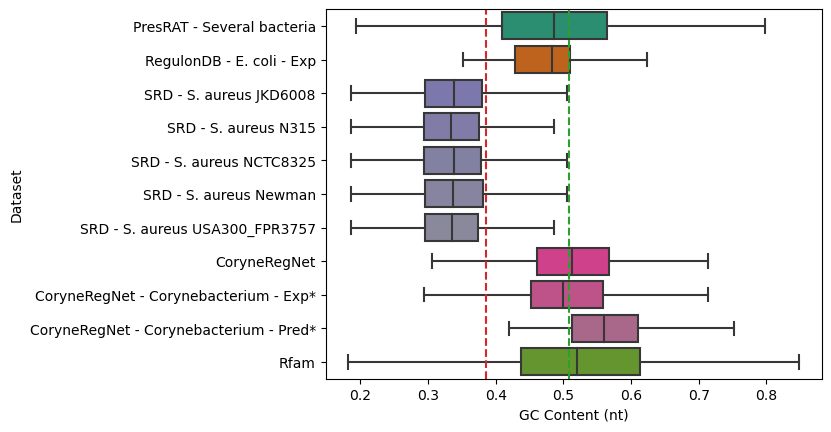

In [83]:
def plot_prop_gc(ax):
  # ax = sns.violinplot(data=df, x='GC_Content', y='dataset')
  sns.boxplot(data=df, x='GC_Content', y='dataset',
              showfliers=False, palette=my_palette, ax=ax)
  ax.set(xlabel='GC Content (nt)', ylabel='Dataset')
  my_set_yticklabels(ax)

  median_geral = df_without_repeats['GC_Content'].median()
  median_without_rfam = df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), 'GC_Content'].median()

  ax.axvline(x=median_geral, linestyle='--', color=my_palette_lines[0])
  ax.axvline(x=median_without_rfam, linestyle='--', color=my_palette_lines[1])
  return ax

plot_prop_gc(plt.subplot())
plt.show()

# Relação de GC Ratio

Relação de conteúdo de G em função de C (GC ratio), conforme utilizado em "MiRNAfe: A comprehensive tool for feature extraction in microRNA prediction" (YONES et al., 2015)

`GC_Ratio = G / C`

In [27]:
# Quantidade por label (dataset)
display( my_describe(df.groupby(['dataset'])['GC_Ratio']) )
display( my_describe(df['GC_Ratio']) )

,count,mean,std,min,25%,50%,75%,max,amplitude,amplitude2
dataset,,,,,,,,,,
CoryneRegNet,922.0,1.069870,0.482280,0.181803,0.758956,1.000000,1.277303,4.500000,4.318197,0.518347
CoryneRegNet-exp,805.0,1.070219,0.505133,0.181803,0.750000,1.000000,1.285744,4.500000,4.318197,0.535744
CoryneRegNet-pred,117.0,1.067475,0.279632,0.549989,0.864873,1.074069,1.206887,2.000051,1.450063,0.342014
PresRAT_sRNA,1174.0,1.090645,0.398059,0.153860,0.847841,1.029845,1.251307,5.333720,5.179860,0.403466
RegulonDB_sRNASet,111.0,1.058811,0.288221,0.500000,0.883483,1.027769,1.211108,1.964318,1.464318,0.327625
Rfam_bacteria,47011.0,1.093701,0.343793,0.272723,0.857139,1.052607,1.282052,8.667657,8.394933,0.424913
SRD_sRNA_JKD6008,606.0,1.117906,0.663048,0.222209,0.714301,0.958341,1.376466,7.499770,7.277561,0.662165
SRD_sRNA_N315,549.0,1.097371,0.579314,0.222209,0.714319,0.958312,1.370125,6.333560,6.111351,0.655806
SRD_sRNA_NCTC8325,538.0,1.112690,0.609406,0.266655,0.720546,0.947358,1.356086,5.333817,5.067162,0.635540


count         52916.000000
mean              1.093575
std               0.369896
min               0.153860
25%               0.846148
50%               1.047600
75%               1.285686
max               8.667657
amplitude         8.513796
amplitude2        0.439538
Name: GC_Ratio, dtype: float64

In [28]:
print('Mediana (sem Rfam):', df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), 'GC_Ratio'].median())
print('Mediana geral:', df_without_repeats['GC_Ratio'].median())

Mediana (sem Rfam): 1.0
Mediana geral: 1.0476181632627795


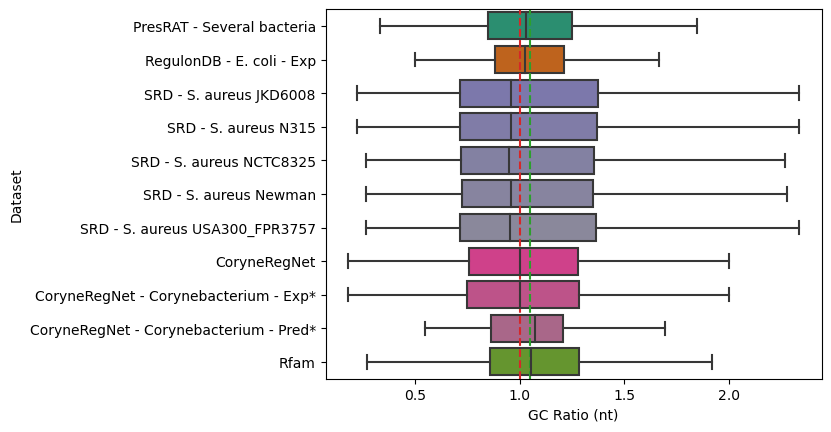

In [86]:
def plot_prop_gcratio(ax):
  # ax = sns.violinplot(data=df, x='GC_Ratio', y='dataset')
  sns.boxplot(data=df, x='GC_Ratio', y='dataset',
              showfliers=False, palette=my_palette, ax=ax)
  ax.set(xlabel='GC Ratio (nt)', ylabel='Dataset')
  my_set_yticklabels(ax)

  median_geral = df_without_repeats['GC_Ratio'].median()
  median_without_rfam = df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), 'GC_Ratio'].median()

  ax.axvline(x=median_geral, linestyle='--', color=my_palette_lines[0])
  ax.axvline(x=median_without_rfam, linestyle='--', color=my_palette_lines[1])

  return ax

plot_prop_gcratio(plt.subplot())
plt.show()

# Grafico: GC Content + GC Ratio

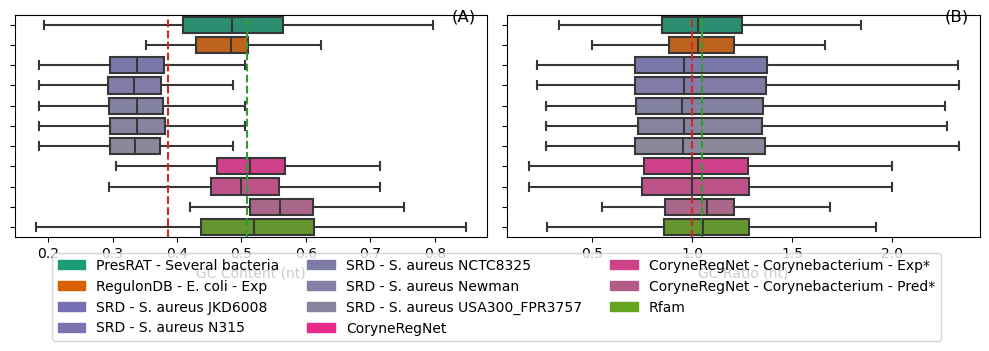

In [89]:
def plot_qtd_tamanho_sequencias():
  cols = ['A', 'B']

  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  labels = None
  for col, ax in zip(cols, axs.flatten()):
    if col == 'A':
      plot_prop_gc(ax)
    else:
      plot_prop_gcratio(ax)
    
    ax.set_title('(' + col + ')', x=0.95, y=0.93)

    if labels is None:
      labels = [label.get_text() for label in ax.get_yticklabels()]

    ax.label_outer()
    # ax.set_yticklabels([])
    ax.set(yticklabels=[])
    ax.set(ylabel=None)

  patches = [mpl.patches.Patch(color=my_palette[i], label=label) for i,label in enumerate(labels)]
  fig.legend(handles=patches,
              loc='lower left',
              bbox_to_anchor=(0.05,-0.175),
              ncol=3,
              bbox_transform=fig.transFigure)

  fig.tight_layout()

plot_qtd_tamanho_sequencias()
plt.show()

# Distribuição de nucleotídeos/espécie

Distribuição de nucleotídeos (k-mer de 1 a 3), conforme utilizado em "MicroRNA categorization using sequence motifs and k-mers" (YOUSEF et al., 2017)

## mono-nucleotídeos

In [30]:
# Quantidade por label (dataset)
# display( my_describe(df.groupby(['dataset'])['A']) )
# display( my_describe(df['A']) )

for nt in ['A', 'C', 'T', 'G']:
  display(nt, my_describe(df_without_repeats.groupby(['dataset'])[nt]) )

display( df_without_repeats[['A', 'C', 'T', 'G']].describe().T )

'A'

,count,mean,std,min,25%,50%,75%,max,amplitude,amplitude2
dataset,,,,,,,,,,
CoryneRegNet-exp,805.0,0.242349,0.068666,0.02941,0.200000,0.240740,0.289060,0.50000,0.47059,0.089060
CoryneRegNet-pred,117.0,0.220771,0.046556,0.08955,0.194440,0.223000,0.243780,0.35294,0.26339,0.049340
PresRAT_sRNA,1174.0,0.244689,0.072853,0.03960,0.192823,0.241380,0.294120,0.53368,0.49408,0.101297
RegulonDB_sRNASet,111.0,0.229694,0.059449,0.09434,0.192665,0.230770,0.266825,0.38596,0.29162,0.074160
Rfam_bacteria,47011.0,0.235352,0.077933,0.01333,0.174600,0.239130,0.292890,0.51316,0.49983,0.118290
SRD_sRNA_JKD6008,606.0,0.316411,0.066857,0.06452,0.276647,0.316375,0.354080,0.51613,0.45161,0.077432
SRD_sRNA_N315,549.0,0.318043,0.066562,0.06452,0.276920,0.319150,0.355120,0.56522,0.50070,0.078200
SRD_sRNA_NCTC8325,538.0,0.317506,0.067267,0.06452,0.276797,0.319115,0.354520,0.51613,0.45161,0.077723
SRD_sRNA_Newman,555.0,0.316198,0.067815,0.06452,0.275395,0.317650,0.353940,0.56522,0.50070,0.078545


'C'

,count,mean,std,min,25%,50%,75%,max,amplitude,amplitude2
dataset,,,,,,,,,,
CoryneRegNet-exp,805.0,0.257728,0.067564,0.05882,0.206900,0.256410,0.295920,0.55882,0.50000,0.089020
CoryneRegNet-pred,117.0,0.278552,0.056118,0.17308,0.240000,0.274510,0.294570,0.52632,0.35324,0.054570
PresRAT_sRNA,1174.0,0.241510,0.071733,0.05172,0.192688,0.238100,0.286718,0.52174,0.47002,0.094030
RegulonDB_sRNASet,111.0,0.237846,0.043712,0.13433,0.203465,0.239130,0.264305,0.33766,0.20333,0.060840
Rfam_bacteria,47011.0,0.258130,0.075070,0.03030,0.200000,0.255320,0.312500,0.57143,0.54113,0.112500
SRD_sRNA_JKD6008,606.0,0.172618,0.054016,0.03448,0.136360,0.169360,0.209173,0.41935,0.38487,0.072813
SRD_sRNA_N315,549.0,0.171046,0.052748,0.02941,0.132740,0.168480,0.207790,0.41935,0.38994,0.075050
SRD_sRNA_NCTC8325,538.0,0.171585,0.053989,0.03448,0.132772,0.170005,0.208000,0.41935,0.38487,0.075228
SRD_sRNA_Newman,555.0,0.171959,0.053849,0.03448,0.132740,0.170130,0.209300,0.41935,0.38487,0.076560


'T'

,count,mean,std,min,25%,50%,75%,max,amplitude,amplitude2
dataset,,,,,,,,,,
CoryneRegNet-exp,805.0,0.249241,0.070382,0.02326,0.205880,0.246030,0.294120,0.47727,0.45401,0.088240
CoryneRegNet-pred,117.0,0.214145,0.051308,0.06579,0.178080,0.222220,0.256410,0.33333,0.26754,0.078330
PresRAT_sRNA,1174.0,0.266631,0.078010,0.04167,0.209300,0.265730,0.321535,0.54237,0.50070,0.112235
RegulonDB_sRNASet,111.0,0.288649,0.069813,0.14620,0.244170,0.281250,0.340360,0.52747,0.38127,0.096190
Rfam_bacteria,47011.0,0.241612,0.072134,0.01493,0.190480,0.236360,0.291670,0.57627,0.56134,0.101190
SRD_sRNA_JKD6008,606.0,0.343341,0.059173,0.15217,0.303938,0.343630,0.381260,0.51613,0.36396,0.077322
SRD_sRNA_N315,549.0,0.345190,0.059732,0.15217,0.309090,0.346150,0.382490,0.51613,0.36396,0.073400
SRD_sRNA_NCTC8325,538.0,0.344034,0.057576,0.17819,0.303938,0.344635,0.379937,0.51613,0.33794,0.076000
SRD_sRNA_Newman,555.0,0.344194,0.057495,0.17391,0.308820,0.344440,0.379425,0.51613,0.34222,0.070605


'G'

,count,mean,std,min,25%,50%,75%,max,amplitude,amplitude2
dataset,,,,,,,,,,
CoryneRegNet-exp,805.0,0.250683,0.064635,0.05405,0.205880,0.243900,0.294120,0.52941,0.47536,0.088240
CoryneRegNet-pred,117.0,0.286533,0.051186,0.20588,0.248520,0.283580,0.319510,0.43137,0.22549,0.070990
PresRAT_sRNA,1174.0,0.247171,0.066409,0.04167,0.201180,0.244010,0.290878,0.50495,0.46328,0.089698
RegulonDB_sRNASet,111.0,0.243812,0.048699,0.11828,0.207635,0.242110,0.278695,0.35013,0.23185,0.071060
Rfam_bacteria,47011.0,0.264906,0.061890,0.06250,0.220930,0.260870,0.307690,0.51471,0.45221,0.086760
SRD_sRNA_JKD6008,606.0,0.167630,0.046952,0.05405,0.135770,0.166275,0.198175,0.32609,0.27204,0.062405
SRD_sRNA_N315,549.0,0.165722,0.044699,0.05238,0.134100,0.163930,0.195120,0.32143,0.26905,0.061020
SRD_sRNA_NCTC8325,538.0,0.166875,0.044129,0.05455,0.135910,0.163455,0.195565,0.32143,0.26688,0.059655
SRD_sRNA_Newman,555.0,0.167650,0.044045,0.05455,0.136360,0.165520,0.196685,0.32143,0.26688,0.060325


,count,mean,std,min,25%,50%,75%,max
A,51994.0,0.240029,0.079217,0.01333,0.17910,0.24359,0.297520,0.56522
C,51994.0,0.253127,0.076338,0.02941,0.19565,0.25000,0.308935,0.57143
T,51994.0,0.247801,0.075229,0.01493,0.19333,0.24194,0.301200,0.57627
G,51994.0,0.259042,0.065099,0.04167,0.21495,0.25641,0.304200,0.52941


In [31]:
L = df_without_repeats.groupby(['dataset'])[['A','T', 'C', 'G']].median()
L['AT_diff'] = abs(L['A'] - L['T']) * 100
L['CG_diff'] = abs(L['C'] - L['G']) * 100
L

,A,T,C,G,AT_diff,CG_diff
dataset,,,,,,
CoryneRegNet-exp,0.240740,0.246030,0.256410,0.243900,0.5290,1.2510
CoryneRegNet-pred,0.223000,0.222220,0.274510,0.283580,0.0780,0.9070
PresRAT_sRNA,0.241380,0.265730,0.238100,0.244010,2.4350,0.5910
RegulonDB_sRNASet,0.230770,0.281250,0.239130,0.242110,5.0480,0.2980
Rfam_bacteria,0.239130,0.236360,0.255320,0.260870,0.2770,0.5550
SRD_sRNA_JKD6008,0.316375,0.343630,0.169360,0.166275,2.7255,0.3085
SRD_sRNA_N315,0.319150,0.346150,0.168480,0.163930,2.7000,0.4550
SRD_sRNA_NCTC8325,0.319115,0.344635,0.170005,0.163455,2.5520,0.6550
SRD_sRNA_Newman,0.317650,0.344440,0.170130,0.165520,2.6790,0.4610


In [32]:
df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), ['A', 'C', 'T', 'G']].describe().T


,count,mean,std,min,25%,50%,75%,max
A,4983.0,0.284153,0.077640,0.02941,0.23256,0.28704,0.337500,0.56522
C,4983.0,0.205930,0.071938,0.02941,0.15517,0.20085,0.250000,0.55882
T,4983.0,0.306193,0.078687,0.02326,0.25455,0.31250,0.359705,0.54237
G,4983.0,0.203723,0.068553,0.04167,0.15190,0.19531,0.245610,0.52941


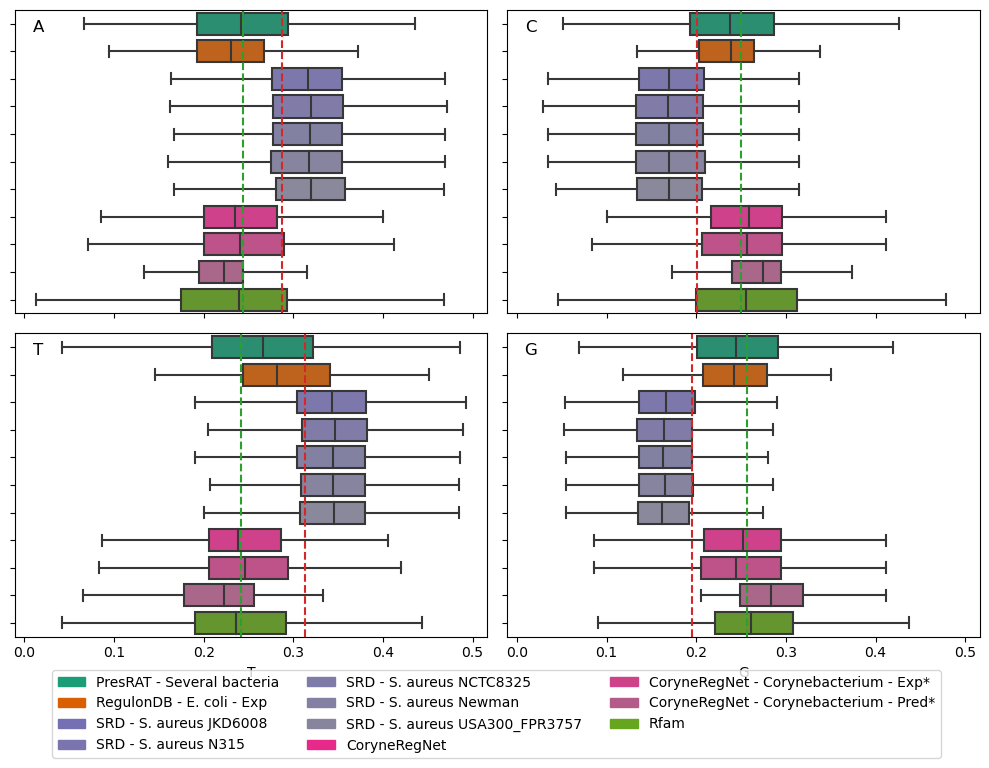

In [33]:
def plot_monont_1():
  nt = ['A', 'C', 'T', 'G']

  cols = nt

  fig, axs = plt.subplots(2, 2, figsize=(10,7), sharex=True)
  labels = None
  for col, ax in zip(cols, axs.flatten()):
    # s = sns.violinplot(data = df, x=col, y='dataset', ax = ax)
    s = sns.boxplot(data = df, x=col, y='dataset', showfliers = False,
                    palette=my_palette, ax = ax)
    ax.set_title(col, x=0.05, y=0.9)
    # ax.set(ylabel='Dataset')
    my_set_yticklabels(ax)

    if labels is None:
      labels = [label.get_text() for label in ax.get_yticklabels()]

    median_geral = df_without_repeats[col].median()
    median_without_rfam = df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), col].median()

    ax.axvline(x=median_geral, linestyle='--', color=my_palette_lines[0])
    ax.axvline(x=median_without_rfam, linestyle='--', color=my_palette_lines[1])

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    # ax.set_yticklabels([])
    ax.set(yticklabels=[])
    ax.set(ylabel=None)

  # labels = axs[0][0].get_yticklabels()
  patches = [mpl.patches.Patch(color=my_palette[i], label=label) for i,label in enumerate(labels)]
  # plt.legend(handles=patches, loc="upper right") # title="Dataset-specie"
  
  fig.legend(handles=patches,
             loc='lower left',
             bbox_to_anchor=(0.05,-0.1),
             ncol=3,
             bbox_transform=fig.transFigure)

  fig.tight_layout()
  plt.show()
  
plot_monont_1()

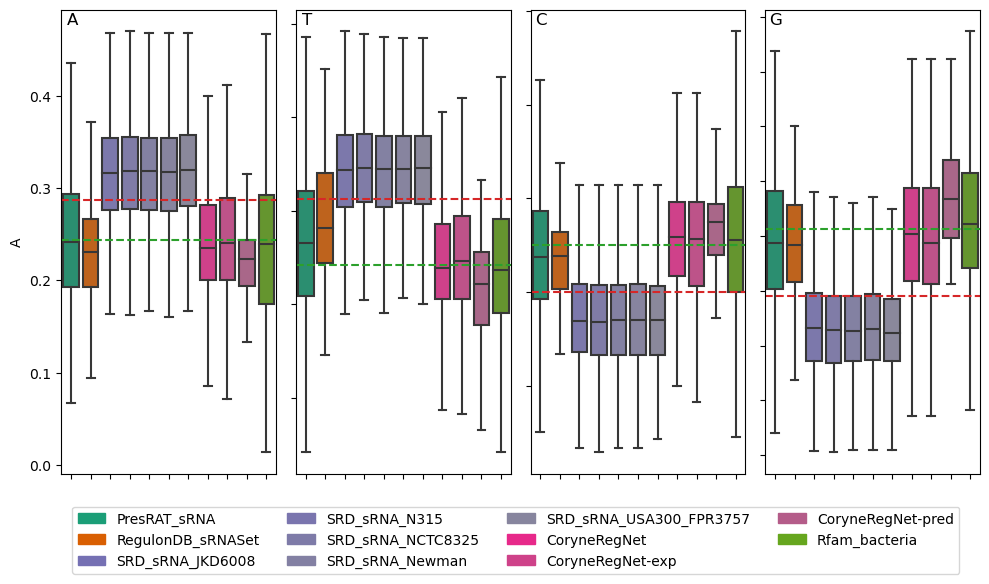

In [106]:
def plot_monont_2():
  nt = ['A', 'T', 'C', 'G']

  cols = nt

  fig, axs = plt.subplots(1, 4, figsize=(10,5))
  labels = None
  for col, ax in zip(cols, axs.flatten()):
    # s = sns.violinplot(data = df, x=col, y='dataset', ax = ax)
    s = sns.boxplot(data = df, x='dataset', y=col, showfliers = False,
                    palette=my_palette, ax = ax)
    ax.set_title(col, x=0.05, y=0.95)
    # ax.set(ylabel='Dataset')
    # my_set_yticklabels(ax)

    if labels is None:
      labels = [label.get_text() for label in ax.get_xticklabels()]

    median_geral = df_without_repeats[col].median()
    median_without_rfam = df_without_repeats.loc[~df_without_repeats['dataset'].isin(['Rfam_bacteria']), col].median()

    ax.axhline(y=median_geral, linestyle='--', color=my_palette_lines[0])
    ax.axhline(y=median_without_rfam, linestyle='--', color=my_palette_lines[1])

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()
    # ax.set_yticklabels([])
    ax.set(xticklabels=[])
    ax.set(xlabel=None)

  # labels = axs[0][0].get_yticklabels()
  patches = [mpl.patches.Patch(color=my_palette[i], label=label) for i,label in enumerate(labels)]
  # plt.legend(handles=patches, loc="upper right") # title="Dataset-specie"
  
  fig.legend(handles=patches,
             loc='lower left',
             bbox_to_anchor=(0.07,-0.175),
             ncol=4,
             bbox_transform=fig.transFigure)

  fig.tight_layout()
  plt.show()
  
plot_monont_2()

## di-nucleotideos

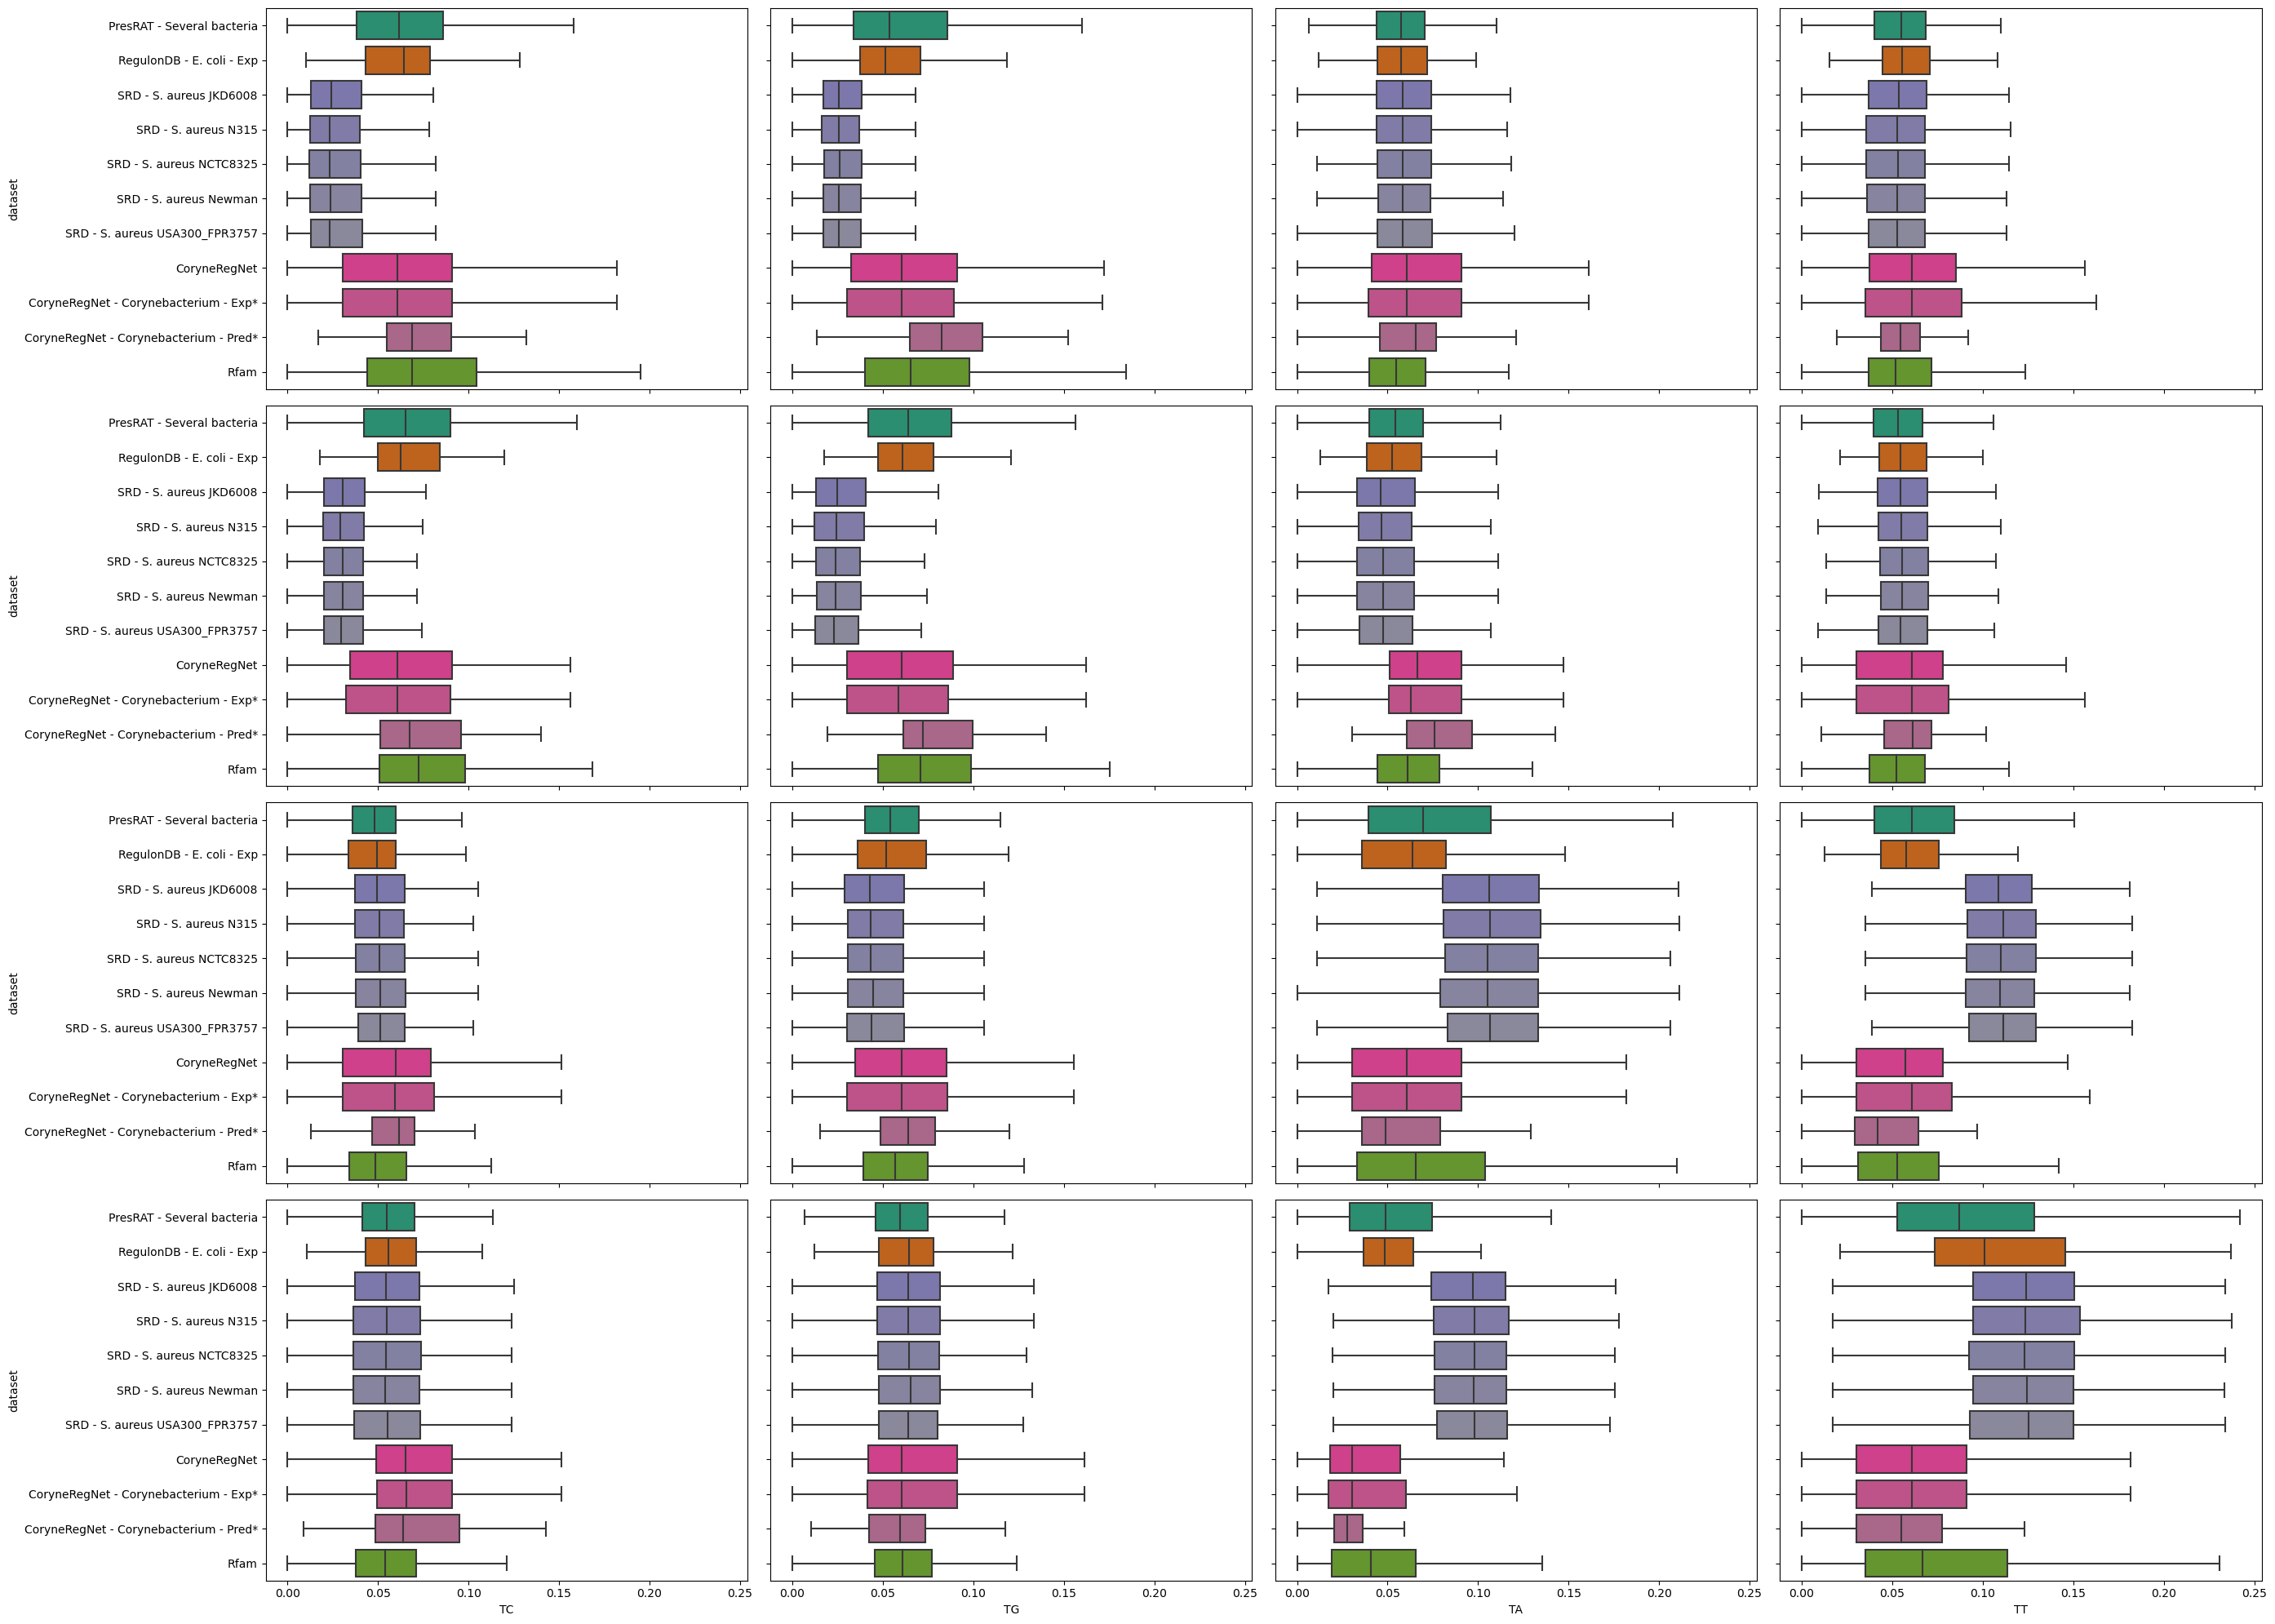

In [34]:
def plot_dint():
  nt = ['C', 'G', 'A', 'T']
  array = np.array([0, 1, 2, 3])
  combinations = np.array(np.meshgrid(array, array, indexing='ij')).T.reshape(-1, 2)

  ncols = len(nt)
  nrows = (ncols ** 2) // ncols

  fig, axs = plt.subplots(nrows, ncols, figsize=(7 * ncols, 5 * nrows), sharex=True)
  for (y, x), ax in zip(combinations, axs.flatten()):
    col = nt[x] + nt[y]
    # s = sns.violinplot(data = df, x=col, y='dataset', ax = ax)
    s = sns.boxplot(data = df, x=col, y='dataset', showfliers = False,
                    palette=my_palette, ax = ax)
    my_set_yticklabels(ax)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()

  fig.tight_layout()
  plt.show()
plot_dint()

## tri-nucleotideos

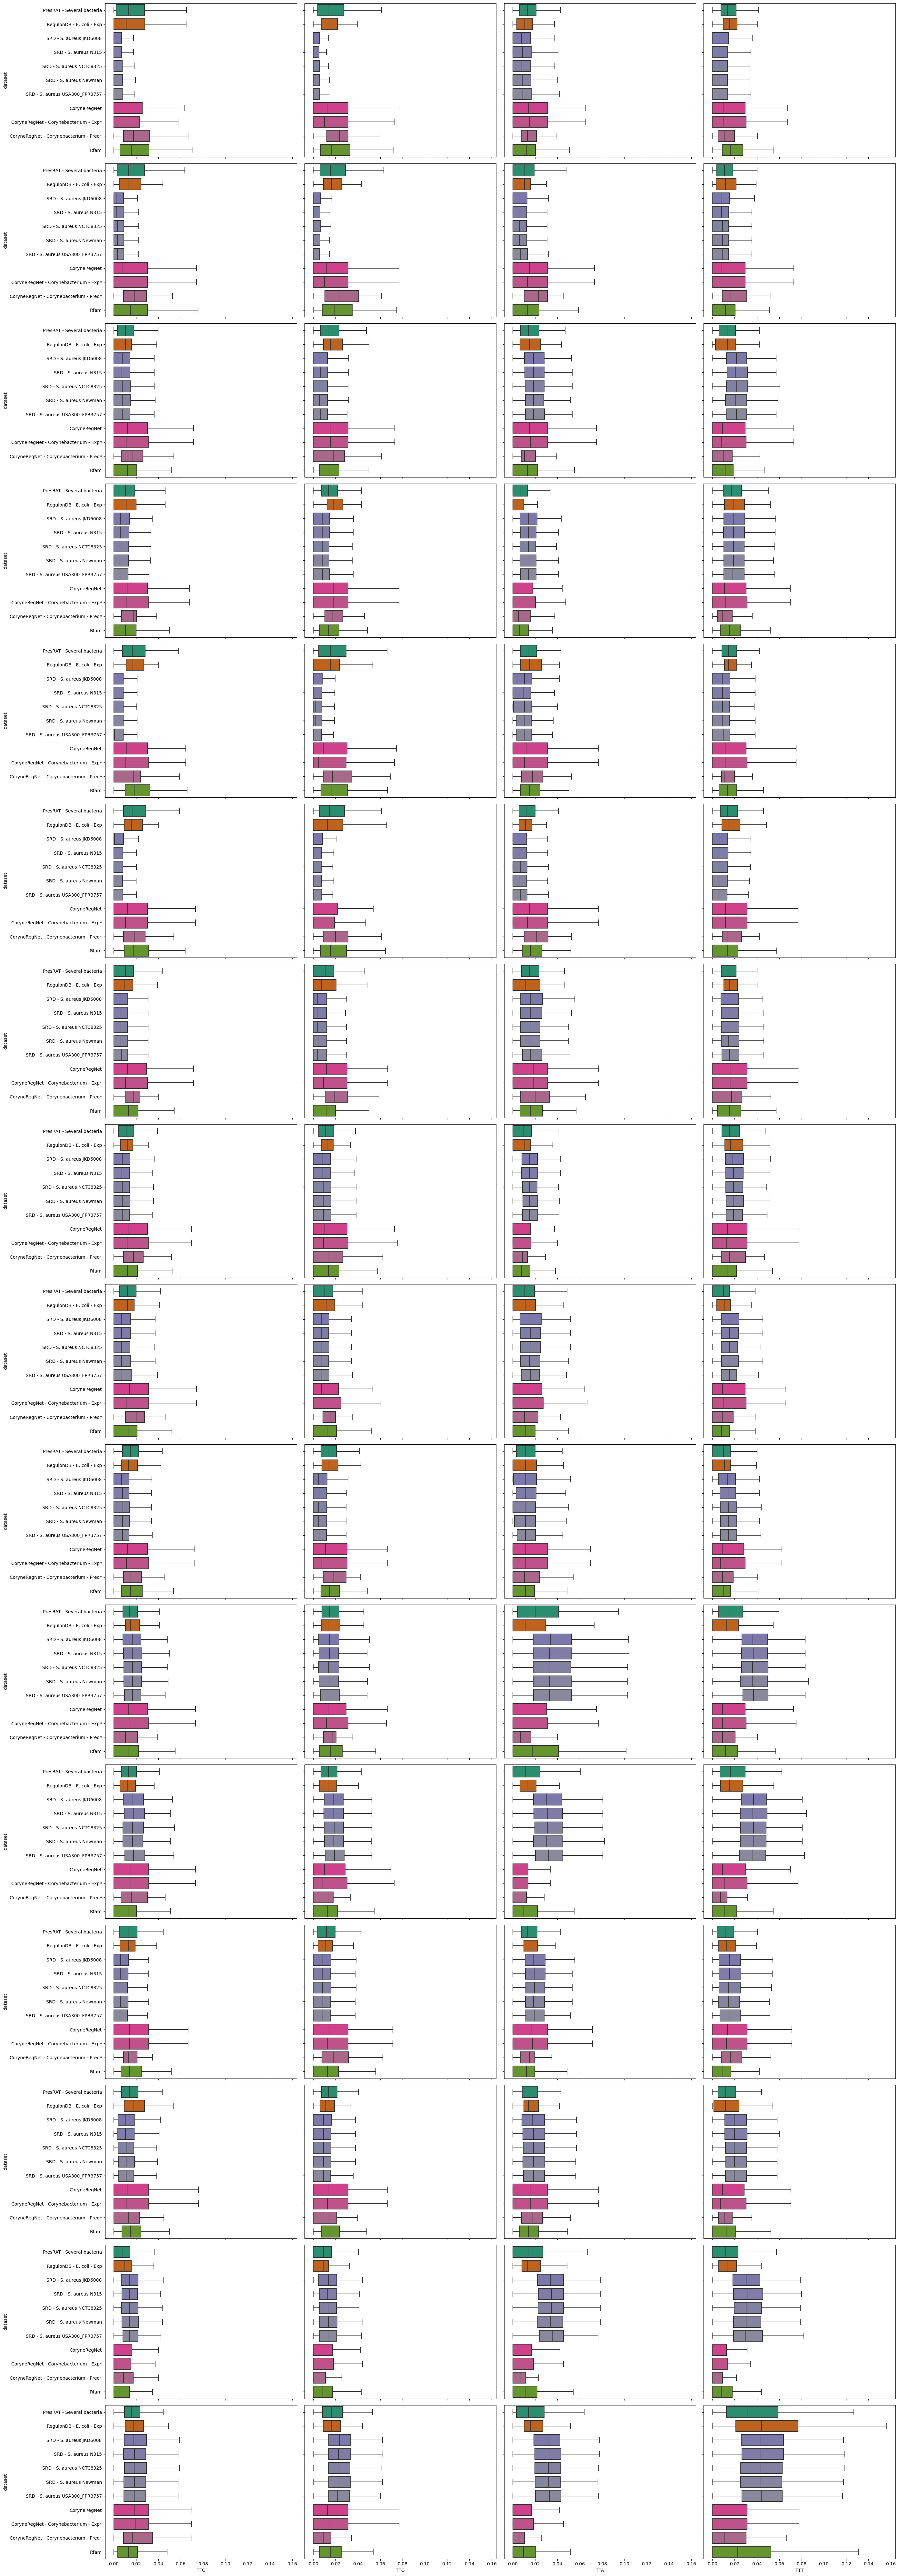

In [35]:
def plot_trint():
  nt = ['C', 'G', 'A', 'T']
  array = np.array([0, 1, 2, 3])
  combinations = np.array(np.meshgrid(array, array, array, indexing='ij')).T.reshape(-1, 3)

  ncols = len(nt)
  nrows = (ncols ** 3) // ncols

  fig, axs = plt.subplots(nrows, ncols, figsize=(7 * ncols, 5 * nrows), sharex=True)
  for (z, y, x), ax in zip(combinations, axs.flatten()):
    col = nt[x] + nt[y] + nt[z]
    # s = sns.violinplot(data = df, x=col, y='dataset', ax = ax)
    s = sns.boxplot(data = df, x=col, y='dataset', showfliers = False,
                    palette=my_palette, ax = ax)
    my_set_yticklabels(ax)

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()

  fig.tight_layout()
  plt.show()
plot_trint()